<img src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500, height=450>
<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

Для быстрого выполнения просмотрите [семинар](https://drive.google.com/file/d/1w_rTEWXQ_SA4YPXFjpkM0aU51bDgWLyI/view?usp=sharing).


### Models: Sentence Sentiment Classification
Our goal is to create a model that takes a sentence (just like the ones in our dataset) and produces either 1 (indicating the sentence carries a positive sentiment) or a 0 (indicating the sentence carries a negative sentiment). We can think of it as looking like this:

<img src="https://jalammar.github.io/images/distilBERT/sentiment-classifier-1.png" />

Under the hood, the model is actually made up of two model.

* DistilBERT processes the sentence and passes along some information it extracted from it on to the next model. DistilBERT is a smaller version of BERT developed and open sourced by the team at HuggingFace. It’s a lighter and faster version of BERT that roughly matches its performance.
* The next model, a basic Logistic Regression model from scikit learn will take in the result of DistilBERT’s processing, and classify the sentence as either positive or negative (1 or 0, respectively).

The data we pass between the two models is a vector of size 768. We can think of this of vector as an embedding for the sentence that we can use for classification.


<img src="https://jalammar.github.io/images/distilBERT/distilbert-bert-sentiment-classifier.png" />

## Dataset
The dataset we will use in this example is [SST2](https://nlp.stanford.edu/sentiment/index.html), which contains sentences from movie reviews, each labeled as either positive (has the value 1) or negative (has the value 0):


<table class="features-table">
  <tr>
    <th class="mdc-text-light-green-600">
    sentence
    </th>
    <th class="mdc-text-purple-600">
    label
    </th>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      apparently reassembled from the cutting room floor of any given daytime soap
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      they presume their audience won't sit still for a sociology lesson
    </td>
    <td class="mdc-bg-purple-50">
      0
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      this is a visually stunning rumination on love , memory , history and the war between art and commerce
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
  <tr>
    <td class="mdc-bg-light-green-50" style="text-align:left">
      jonathan parker 's bartleby should have been the be all end all of the modern office anomie films
    </td>
    <td class="mdc-bg-purple-50">
      1
    </td>
  </tr>
</table>

## Installing the transformers library
Let's start by installing the huggingface transformers library so we can load our deep learning NLP model.

In [3]:
#!pip install transformers

[Transformers library doc](https://huggingface.co/transformers/)

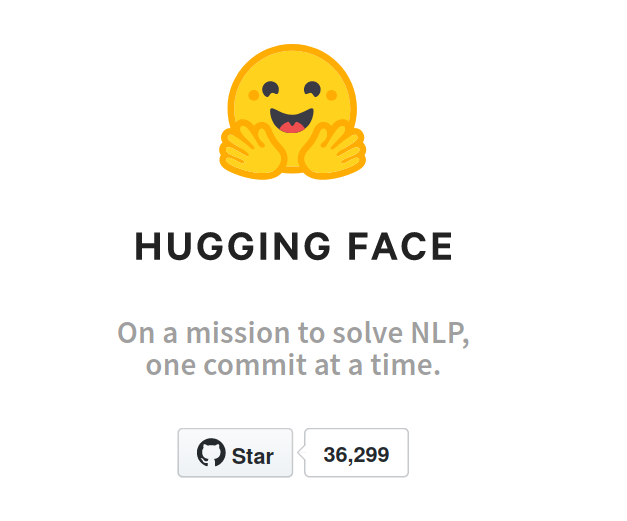

In [4]:
# run twice

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
from transformers import get_cosine_schedule_with_warmup
warnings.filterwarnings('ignore')

### Importing the dataset

In [5]:
df = pd.read_csv(
    'https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv',
    delimiter='\t',
    header=None
)
print(df.shape)
df.head()

(6920, 2)


,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


### Using BERT for text classification.

Let's now load a pre-trained BERT model. 

In [6]:
# For DistilBERT, Load pretrained model/tokenizer:

model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [7]:
# look at the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [8]:
from termcolor import colored

colors = ['red', 'green', 'blue', 'yellow']

def model_structure(layer, margin=0, item_color=0):
    for name, next_layer in layer.named_children():

        next = (0 if not list(next_layer.named_children()) else 1)
        print(colored(' ' * margin + name, colors[item_color]) + ':' * next)
        model_structure(next_layer, margin + len(name) + 2, (item_color + 1) % 4)

model_structure(model)

embeddings:
            word_embeddings
            position_embeddings
            LayerNorm
            dropout
transformer:
             layer:
                    0:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                            lin1
                            lin2
                       output_layer_norm
                    1:
                       attention:
                                  dropout
                                  q_lin
                                  k_lin
                                  v_lin
                                  out_lin
                       sa_layer_norm
                       ffn:
                            dropout
                      

### Preparing the dataset

In [9]:
from torch.utils.data import Dataset, random_split

class ReviewsDataset(Dataset):
    def __init__(self, reviews, tokenizer, labels):
        self.labels = labels
        # tokenized reviews
        self.tokenized = [tokenizer.encode(i, add_special_tokens=True) for i in reviews] #'''your code'''
        
    def __getitem__(self, idx):
        return {"tokenized": self.tokenized[idx], "label": self.labels[idx]}

    def __len__(self):
        return len(self.labels)

dataset = ReviewsDataset(list(df[0]),tokenizer,list(df[1]))

# DON'T CHANGE, PLEASE
train_size, val_size = int(.8 * len(dataset)), int(.1 * len(dataset))
torch.manual_seed(2) 
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 5536
Number of validation examples: 692
Number of testing examples: 692


In [10]:
from torch.utils.data import Sampler

class ReviewsSampler(Sampler):
    def __init__(self, subset, batch_size=32):
        self.batch_size = batch_size
        self.subset = subset

        self.indices = subset.indices
        # tokenized for our data
        self.tokenized = np.array(subset.dataset.tokenized)[self.indices]

    def __iter__(self):

        batch_idx = []
        # index in sorted data
        for index in np.argsort(list(map(len, self.tokenized))):
            batch_idx.append(index)
            if len(batch_idx) == self.batch_size:
                yield batch_idx
                batch_idx = []

        if len(batch_idx) > 0:
            yield batch_idx

    def __len__(self):
        return len(self.dataset)

In [11]:
from torch.utils.data import DataLoader

def get_padded(values):
    max_len = 0
    for value in values:
        if len(value) > max_len:
            max_len = len(value)

    padded = np.array([value + [0]*(max_len-len(value)) for value in values])

    return padded

def collate_fn(batch):

    inputs = []
    labels = []
    for elem in batch:
        inputs.append(elem['tokenized'])
        labels.append(elem['label'])

    inputs = get_padded(inputs) # '''your code''' # padded inputs
    attention_mask = (inputs!=0).astype('int') #'''your code'''

    return {"inputs": torch.tensor(inputs), "labels": torch.FloatTensor(labels), 'attention_mask' : torch.tensor(attention_mask)}

train_loader = DataLoader(train_data, batch_sampler=ReviewsSampler(train_data), collate_fn=collate_fn)
valid_loader = DataLoader(valid_data, batch_sampler=ReviewsSampler(valid_data), collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_sampler=ReviewsSampler(test_data), collate_fn=collate_fn)

### Baseline

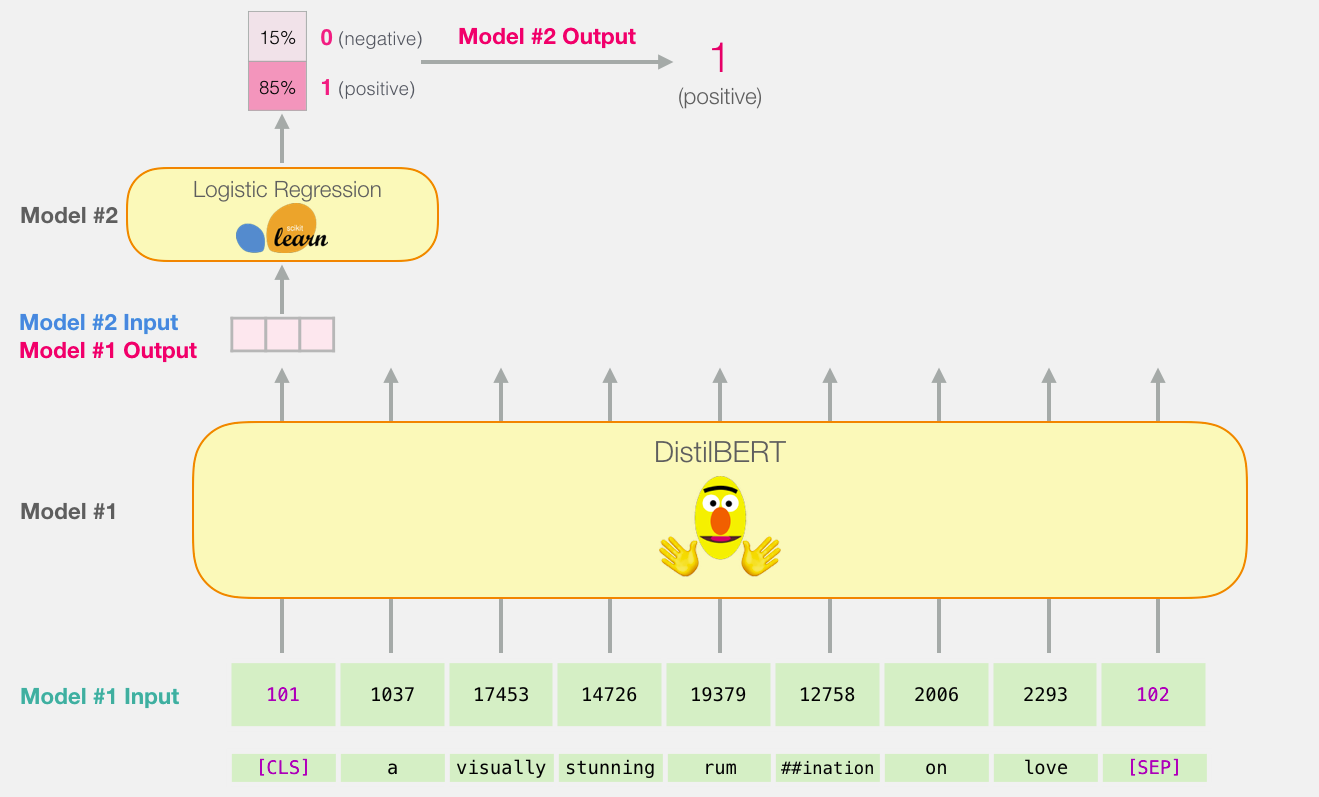

In [12]:
from tqdm.notebook import tqdm

def get_xy(loader):
    features = []
    labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            
            # don't forget about .to(device)
            labels.append(batch['labels'])
            inputs = batch['inputs'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            last_hidden_states = model(inputs, attention_mask)
            
            features.append(last_hidden_states[0].cpu())

    features = torch.cat([elem[:, 0, :] for elem in features], dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    return features, labels

In [13]:
train_features, train_labels = get_xy(train_loader)
valid_features, valid_labels = get_xy(valid_loader)
test_features, test_labels = get_xy(test_loader)

In [14]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)
lr_clf.score(test_features, test_labels)

0.8222543352601156

### Fine-Tuning BERT

Define the model

In [86]:
from torch import nn

class BertClassifier(nn.Module):
    def __init__(self, pretrained_model, dropout=0.1):
        super().__init__()
        
        self.bert = pretrained_model
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(768, affine=False)
        
        #'''your code'''
        
        sizes=[768,768]
        layers = []
        for i in range(len(sizes)-1):
            layers.append(nn.Linear(sizes[i],sizes[i+1]))
            layers.append(nn.Dropout(p=dropout))
            layers.append(nn.Tanh())
            layers.append(nn.BatchNorm1d(sizes[i+1]))
        layers.append(nn.Linear(sizes[-1],1))
        self.linear = nn.Sequential(*layers)     
        self.sigmoid = nn.Sigmoid()
        
    
    def forward(self, inputs, attention_mask): 
        
        #'''your code'''
        afterbert = self.bert(inputs, attention_mask)[0][:, 0, :]
        afterbert = self.dropout(afterbert)
        afterbert = self.relu(afterbert)
        afterbert = self.bn(afterbert)
        
        afterlinear = self.linear(afterbert)
        proba = self.sigmoid(afterlinear)
        # proba = [batch_size, ] - probability to be positive
        return proba

In [94]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        # don't forget about .to(device)
        # '''your code'''
        
        optimizer.zero_grad()
        
        labels = batch['labels'].to(device)
        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        output = model(inputs, attention_mask)
        
        
        # '''your code'''

        loss = criterion(output, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / (i + 1)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            # '''your code'''
            labels = batch['labels'].to(device)
            inputs = batch['inputs'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            output = model(inputs, attention_mask)

            loss = criterion(output, labels)
            
            epoch_loss += loss.item()
        
    return epoch_loss / (i + 1)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [95]:
import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

# Define model

In [112]:
import torch.optim as optim

# DON'T CHANGE
model = model_class.from_pretrained(pretrained_weights).to(device)
bert_clf = BertClassifier(model).to(device)

In [113]:
train_history = []
valid_history = []
best_valid_loss = float('inf')

# First train the new linear head

In [114]:
# freeze bert, unfreeze linear
bert_clf.bert.requires_grad_ = False
bert_clf.linear.requires_grad_ = True
# not too many epochs
N_EPOCHS = 40
CLIP = 1
optimizer = optim.Adam(bert_clf.linear.parameters(), lr=3e-4)
# simple scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=10)
criterion = nn.BCELoss()

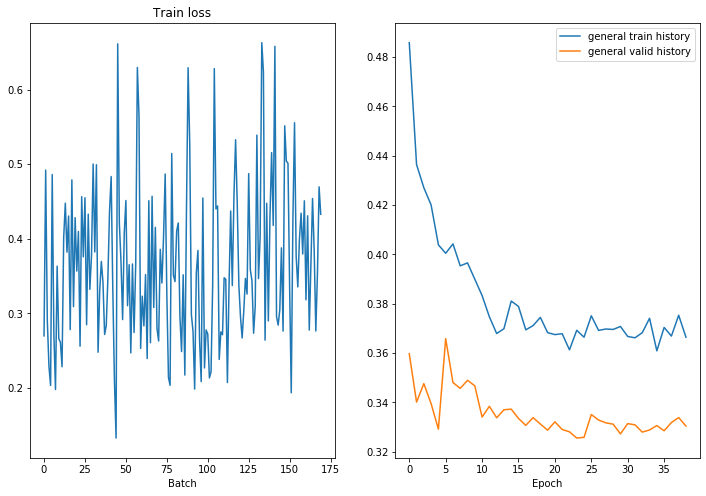

Epoch: 40 | Time: 0m 10s
	Train Loss: 0.366 | Train PPL:   1.442
	 Val. Loss: 0.331 |  Val. PPL:   1.393


In [115]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(bert_clf, valid_loader, criterion)
    scheduler.step(valid_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model.pt')
        
    scheduler.step(valid_loss)
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

# Now unfreeze the rest

In [116]:
# load the best model
bert_clf = BertClassifier(model).to(device)
bert_clf.load_state_dict(torch.load('best-val-model.pt'))

<All keys matched successfully>

In [117]:
# freeze bert, unfreeze linear
bert_clf.requires_grad_ = True
# more epochs
N_EPOCHS = 300
CLIP = 1
optimizer = optim.Adam(bert_clf.parameters(), lr=3e-5)
# cheekier scheduler
scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=50, num_training_steps=N_EPOCHS)
criterion = nn.BCELoss()

In [118]:
train_history = []
valid_history = []

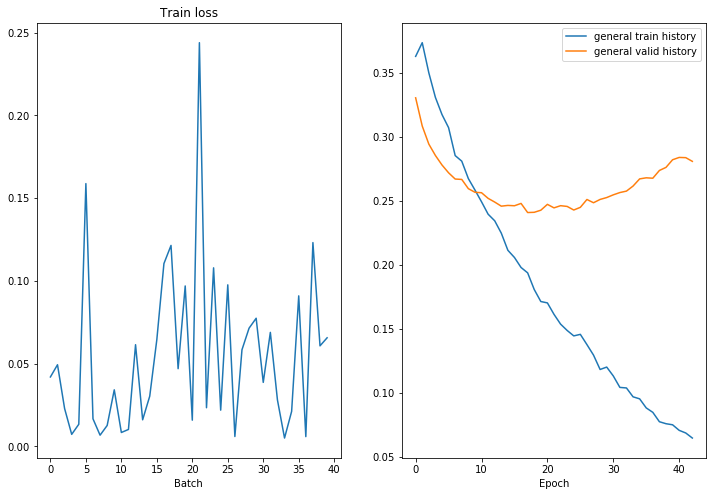

KeyboardInterrupt: 

In [119]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(bert_clf, train_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(bert_clf, valid_loader, criterion)
    scheduler.step(valid_loss)
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(bert_clf.state_dict(), 'best-val-model.pt')
        
    scheduler.step()
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

# Test

In [120]:
best_model = BertClassifier(model).to(device)
best_model.load_state_dict(torch.load('best-val-model.pt'))

pred_labels = []
true_labels = []

best_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        #'''your code'''
        labels = batch['labels']
        
        true_labels.append(labels.numpy())

        #'''your code'''
        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        output = best_model(inputs, attention_mask)
        pred_labels.append((output>0.5).to('cpu'))

In [121]:
from sklearn.metrics import accuracy_score

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
accuracy_score(true_labels, pred_labels)

0.8554913294797688

In [122]:
assert accuracy_score(true_labels, pred_labels) >= 0.87

AssertionError: 

### Finetuned model from **HUGGING FACE**

[BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html?highlight=bertfor#transformers.BertForSequenceClassification)

In [317]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# we have the same tokenizer
# new_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
new_model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english").to(device)

In [326]:
pred_labels = []
true_labels = []

new_model.eval()
with torch.no_grad():
    for i, batch in tqdm(enumerate(test_loader)):

        #'''your code'''
        labels = batch['labels']
        
        true_labels.append(labels.numpy())

        #'''your code'''
        inputs = batch['inputs'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        output = new_model(inputs, attention_mask)[0]
        pred_labels.append((output[:,1]>output[:,0]).to('cpu'))

true_labels = np.concatenate(true_labels, axis=0)
pred_labels = np.concatenate(pred_labels, axis=0)
accuracy_score(true_labels, pred_labels)

0.9841040462427746

In [327]:
model_structure(new_model)

distilbert:
            embeddings:
                        word_embeddings
                        position_embeddings
                        LayerNorm
                        dropout
            transformer:
                         layer:
                                0:
                                   attention:
                                              dropout
                                              q_lin
                                              k_lin
                                              v_lin
                                              out_lin
                                   sa_layer_norm
                                   ffn:
                                        dropout
                                        lin1
                                        lin2
                                   output_layer_norm
                                1:
                                   attention:
                                              dropo

## Напишите вывод о своих результатах. В выводы включите ваши гиперпараметры. 

*Качество с помощью Fine-Tuning должно достигать 0.87.*

